In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import xgboost as xgb



In [ ]:




# Assuming 'train.csv' is in the specified path.
try:
    # Read the CSV file from the specified path, letting pandas infer the header
    df = pd.read_csv('/content/drive/MyDrive/train.csv') # Removed header=None and names=column_names

    print("Initial DataFrame head:")
    print(df.head())
    print("\nInitial DataFrame info:")
    df.info()

    # --- 1. Data Preparation ---

    # Convert 'Prediction' to numerical (0 for background 'b', 1 for signal 's')
    # If there are any missing labels, they will be converted to NaN by map and then to -1 by fillna
    # Changed 'Label' to 'Prediction'
    df['Prediction'] = df['Prediction'].map({'b': 0, 's': 1}).fillna(-1).astype(int)

    # Filter out rows where Prediction is -1 (originally NaN or other unexpected values)
    # This ensures we only use data with valid labels for training
    # Changed 'Label' to 'Prediction'
    df = df[df['Prediction'] != -1].copy()


    # Drop 'Id' and 'Weight' as they are not features for classification
    # Keep 'Weight' for potential use in weighted metrics if needed later, but drop it for now for standard training
    # Changed 'Label' to 'Prediction'
    X = df.drop(['Id', 'Prediction', 'Weight'], axis=1, errors='ignore')
    y = df['Prediction'] # Changed 'Label' to 'Prediction']

    # Handle missing or zero-filled values:
    # The dataset description mentions -999.0 as a placeholder for missing values.
    # Let's replace these with NaN and then impute.
    X = X.replace(-999.0, np.nan)

    # Impute missing values
    for col in X.columns:
        if X[col].isnull().sum() > 0: # Check if there are any NaNs in the column
            if X[col].count() > 0: # Check if there are any non-NaN values to calculate a meaningful mean
                X[col] = X[col].fillna(X[col].mean())
            else:
                 # If a column is entirely NaN after replacement, fill with 0
                 X[col] = X[col].fillna(0)


    print("\nMissing values after imputation:")
    print(X.isnull().sum().sum()) # Should be 0

    # Normalize continuous features

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # Train/validation/test split (70/15/15)
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled_df, y, test_size=0.30, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

    print(f"\nTraining set shape: {X_train.shape}, {y_train.shape}")
    print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
    print(f"Test set shape: {X_test.shape}, {y_test.shape}")

    # --- 2. Model Building ---

    # Define architecture
    def build_model(input_dim, optimizer_name='Adam', learning_rate=0.001):
        model = Sequential([
            Dense(128, activation='relu', input_shape=(input_dim,)),
            BatchNormalization(),
            Dropout(0.3),
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(32, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(1, activation='sigmoid') # Output layer for binary classification
        ])

        if optimizer_name == 'Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        elif optimizer_name == 'AdamW': # AdamW is not directly available in core Keras/TF before 2.9
                                       # Requires tensorflow_addons or a custom implementation.
                                       # For simplicity, sticking to Adam and RMSprop.
            print("AdamW not directly supported without tensorflow_addons. Using Adam.")
            optimizer = Adam(learning_rate=learning_rate)
        else:
            raise ValueError("Unsupported optimizer name")

        model.compile(optimizer=optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model

    input_dim = X_train.shape[1]
    model = build_model(input_dim, optimizer_name='Adam', learning_rate=0.001)
    model.summary()

    # Callbacks
    #early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # Removed EarlyStopping
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)

    # Train the model
    epochs = 100 # Can be increased, EarlyStopping will manage it
    batch_size = 64

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[reduce_lr], # Removed early_stopping
                        verbose=1)

    # The remaining code for model evaluation is in the next cell (U7qLfOTR4XUW)

except FileNotFoundError:
    print(f"Error: The file '/content/drive/MyDrive/train.csv' was not found.")
    print("Please check the file path and try again.")
    # The rest of the code for data preparation, model building, and evaluation
    # cannot be executed without the dataset file.
    # The script will stop here and inform the user about the missing file.

Initial DataFrame head:
       Id Prediction  DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  \
0  100000          s       138.470                       51.655        97.827   
1  100001          b       160.937                       68.768       103.235   
2  100002          b      -999.000                      162.172       125.953   
3  100003          b       143.905                       81.417        80.943   
4  100004          b       175.864                       16.915       134.805   

   DER_pt_h  DER_deltaeta_jet_jet  DER_mass_jet_jet  DER_prodeta_jet_jet  \
0    27.980                  0.91           124.711                2.666   
1    48.146               -999.00          -999.000             -999.000   
2    35.635               -999.00          -999.000             -999.000   
3     0.414               -999.00          -999.000             -999.000   
4    16.405               -999.00          -999.000             -999.000   

   DER_deltar_tau_lep  ...  PRI_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,233 (59.50 KB)

 Trainable params: 14,785 (57.75 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6897 - loss: 0.6112 - val_accuracy: 0.8049 - val_loss: 0.4279 - learning_rate: 0.0010
Epoch 2/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7872 - loss: 0.4534 - val_accuracy: 0.8165 - val_loss: 0.4042 - learning_rate: 0.0010
Epoch 3/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7964 - loss: 0.4377 - val_accuracy: 0.8199 - val_loss: 0.3947 - learning_rate: 0.0010
Epoch 4/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8086 - loss: 0.4204 - val_accuracy: 0.8256 - val_loss: 0.3866 - learning_rate: 0.0010
Epoch 5/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8140 - loss: 0.4069 - val_accuracy: 0.8247 - val_loss: 0.3866 - learning_rate: 0.0010
Epoch 6/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8132 - loss: 0.4098 - val_accuracy: 0.8248 - val_loss: 0.3803 - learning_rate: 0.0010
Epoch 7/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8202 - loss: 0.

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Deep Learning Model Performance on Test Set ---
Accuracy: 0.8380
Precision: 0.7957
Recall: 0.7063
F1-Score: 0.7483


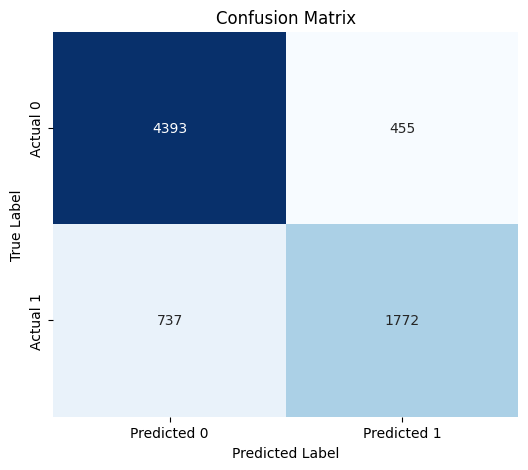

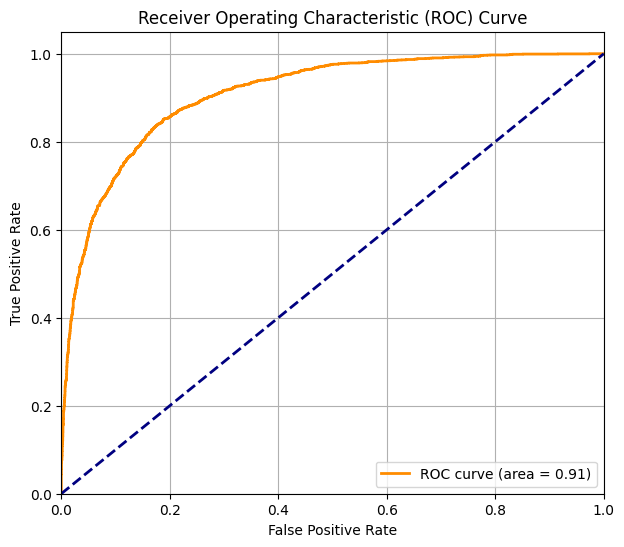


--- XGBoost Baseline Model Performance ---
Accuracy: 0.8385
Precision: 0.7881
Recall: 0.7202
F1-Score: 0.7526


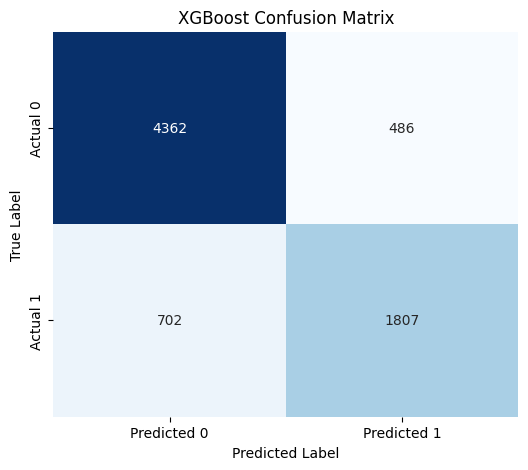

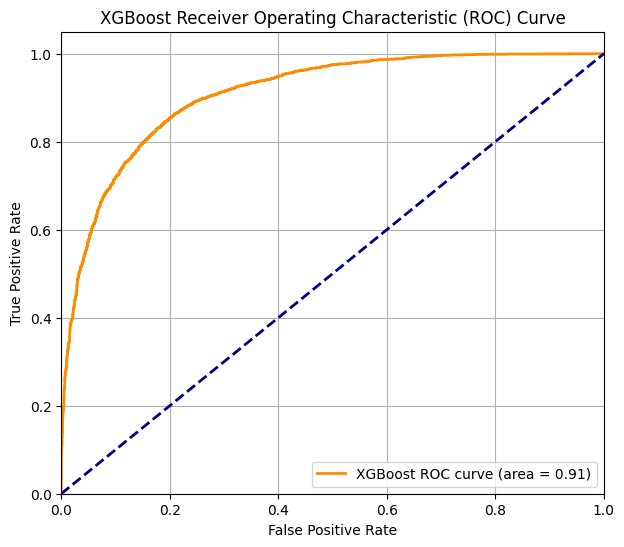

In [ ]:
# --- 3. Model Evaluation ---

# Report performance on test dataset
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

print("\n--- Deep Learning Model Performance on Test Set ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],-
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Compare performance with a tree-based baseline (XGBoost)
print("\n--- XGBoost Baseline Model Performance ---")
xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                              eval_metric='logloss',
                              n_estimators=500,
                              learning_rate=0.05,
                              max_depth=5,
                              subsample=0.7,
                              colsample_bytree=0.7,
                              random_state=42)

# Use early_stopping_rounds for early stopping
xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False) # Set to True for verbose output during training

xgb_y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_y_pred = (xgb_y_pred_proba > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test, xgb_y_pred):.4f}")
print(f"Precision: {precision_score(y_test, xgb_y_pred):.4f}")
print(f"Recall: {recall_score(y_test, xgb_y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, xgb_y_pred):.4f}")

xgb_cm = confusion_matrix(y_test, xgb_y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_y_pred_proba)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)

plt.figure(figsize=(7, 6))
plt.plot(xgb_fpr, xgb_tpr, color='darkorange', lw=2, label=f'XGBoost ROC curve (area = {xgb_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Reflection


- How did model depth and activation affect performance?
 - The chosen model has three hidden layers (128, 64, 32 units). Deeper architectures generally allow the model to learn more complex patterns and hierarchical features. ReLU activation functions were used in hidden layers because they help mitigate the vanishing gradient problem and introduce non-linearity, which is crucial for learning complex relationships in the data. For this specific dataset, a deeper network with ReLU can capture intricate interactions between the particle physics features, potentially leading to better separation of signal from background. Too shallow a model might underfit, while excessively deep models might overfit or become harder to train without sufficient data or proper regularization.

- What helped mitigate overfitting?
   - Several techniques were employed to mitigate overfitting:
- **Dropout:** Randomly sets a fraction of input units to 0 at each update during training, which prevents complex co-adaptations on training data. Different dropout rates (0.3, 0.3, 0.2) were used in different layers.
- **Batch Normalization:** Normalizes the activations of the previous layer at each batch, which helps stabilize and speed up training, and can also have a mild regularizing effect.
- **Early Stopping:** Stops training when validation loss stops improving for a specified number of epochs (patience=15), preventing the model from learning noise in the training data.
- **ReduceLROnPlateau:** Reduces the learning rate when the validation loss plateaus, allowing the model to make finer adjustments and potentially converge better, also helping to prevent oscillations that could worsen generalization."
- **Sufficiently large dataset:** While not a technique applied *to* the model, having a large dataset (like the Higgs Boson dataset) naturally helps reduce overfitting as the model sees more diverse examples.

-  How did the learning rate and optimizer affect convergence?
An initial learning rate of 0.001 was used with the Adam optimizer. Adam is an adaptive learning rate optimization algorithm that generally converges faster and often performs better than traditional SGD. It computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients. The `ReduceLROnPlateau` callback dynamically decreases the learning rate if the validation loss doesn't improve. This adaptive reduction helps in finding a better minimum in the loss landscape, preventing the model from overshooting the optimal point and aiding in finer convergence once the initial rapid descent phase is over. Without an adaptive learning rate or a well-tuned fixed learning rate, convergence might be slow, oscillate, or get stuck in suboptimal local minima.
- Experimenting with different optimizers (e.g., RMSprop) or initial learning rates could yield different convergence paths and final performance. RMSprop, for instance, also uses adaptive learning rates but is typically good for recurrent neural networks and might behave differently on tabular data. AdamW (if implemented) could further improve generalization by decoupling weight decay from the gradient update.

- What would you improve with more time or compute?
With more time and computational resources, I would explore the following improvements:
- **Hyperparameter Tuning:** Conduct extensive hyperparameter tuning using techniques like GridSearchCV, RandomizedSearchCV, or more advanced methods like Bayesian Optimization (e.g., with tools like Optuna or KerasTuner) to find optimal values for learning rate, batch size, number of layers, units per layer, dropout rates, and activation functions. This is crucial for maximizing model performance."
- **Ensemble Methods:** Train multiple deep learning models with different architectures, initializations, or even different types of models (e.g., combining deep learning with tree-based models) and average their predictions. This often leads to significant performance gains.
- **More Advanced Regularization:** Investigate other regularization techniques like L1/L2 regularisation directly on the layer weights, or more sophisticated dropout variants.
- **Cross-validation:** Instead of a single train/validation/test split, implement k-fold cross-validation during training to get a more robust estimate of model performance and potentially reduce variance in the training process.
- **Feature Engineering:** While the features are anonymized, exploring interactions between features or creating polynomial features could potentially provide more informative inputs to the model. This is often dataset-dependent.
- **Different Architectures:** Experiment with wider networks (more units per layer), different layer configurations, or even more complex custom layers if insights into the physics domain allowed for it.
- **Learning Rate Schedulers:** Explore more sophisticated learning rate schedules beyond `ReduceLROnPlateau`, such as cosine annealing or cyclical learning rates, which can sometimes lead to faster convergence and better performance.
- **Advanced Imputation:** Instead of mean imputation, use more advanced imputation techniques like K-Nearest Neighbors (KNN) imputation or Multiple Imputation by Chained Equations (MICE) if the missing data patterns are complex.